# Preparing Data from the MIMIC-III Database
In preparation of predicting hospital readmissions, data from the NOTEVENTS and ADMISSIONS tables of the MIMIC-III database will be pulled into a pandas DataFrame and cleaned.

In [158]:
# import libraries
import os
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Table

%matplotlib inline
%load_ext watermark

PROJ_ROOT = os.path.join(os.pardir)

In [159]:
%watermark -a "E. Chris Lynch" -d -t -v -p numpy,pandas,matplotlib,sqlalchemy

E. Chris Lynch 2018-12-17 15:12:48 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
pandas 0.23.4
matplotlib 3.0.2
sqlalchemy 1.2.15


In [2]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

database_url = os.environ.get("DATABASE_URL")

In [3]:
# initiate PostgreSQL engine
engine = create_engine(database_url,
    connect_args={'options': '-csearch_path=mimiciii'}
)
connection = engine.connect()

In [4]:
metadata = MetaData()

# define NOTEEVENTS table
notes = Table('noteevents', metadata, autoload=True, autoload_with=engine)

In [5]:
# Print the column names
print('COLUMN NAMES')
print(notes.columns.keys())

# Print full table metadata
print('\nMETADATA')
print(repr(notes))

COLUMN NAMES
['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime', 'storetime', 'category', 'description', 'cgid', 'iserror', 'text']

METADATA
Table('noteevents', MetaData(bind=None), Column('row_id', INTEGER(), table=<noteevents>, primary_key=True, nullable=False), Column('subject_id', INTEGER(), table=<noteevents>, nullable=False), Column('hadm_id', INTEGER(), table=<noteevents>), Column('chartdate', TIMESTAMP(precision=0), table=<noteevents>), Column('charttime', TIMESTAMP(precision=0), table=<noteevents>), Column('storetime', TIMESTAMP(precision=0), table=<noteevents>), Column('category', VARCHAR(length=50), table=<noteevents>), Column('description', VARCHAR(length=255), table=<noteevents>), Column('cgid', INTEGER(), table=<noteevents>), Column('iserror', CHAR(length=1), table=<noteevents>), Column('text', TEXT(), table=<noteevents>), schema=None)


In [8]:
# return a count of records by category
query = 'SELECT COUNT(row_id) as Count, category \
        FROM noteevents \
        GROUP BY category \
        ORDER BY Count DESC'
cat_counts = connection.execute(query).fetchall()
for count, cat in cat_counts:
    print('{0}: {1}'.format(cat, count))

Nursing/other: 822497
Radiology: 522279
Nursing: 223556
ECG: 209051
Physician : 141624
Discharge summary: 59652
Echo: 45794
Respiratory : 31739
Nutrition: 9418
General: 8301
Rehab Services: 5431
Social Work: 2670
Case Management : 967
Pharmacy: 103
Consult: 98


## Extract data from ADMISSIONS table

In [31]:
# define ADMISSIONS table
admit = Table('admissions', metadata, autoload=True, autoload_with=engine)

# Print the column names
print('COLUMN NAMES')
print(admit.columns.keys())

# Print full table metadata
print('\nMETADATA')
print(repr(admit))

COLUMN NAMES
['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data']

METADATA
Table('admissions', MetaData(bind=None), Column('row_id', INTEGER(), table=<admissions>, primary_key=True, nullable=False), Column('subject_id', INTEGER(), table=<admissions>, nullable=False), Column('hadm_id', INTEGER(), table=<admissions>, nullable=False), Column('admittime', TIMESTAMP(precision=0), table=<admissions>, nullable=False), Column('dischtime', TIMESTAMP(precision=0), table=<admissions>, nullable=False), Column('deathtime', TIMESTAMP(precision=0), table=<admissions>), Column('admission_type', VARCHAR(length=50), table=<admissions>, nullable=False), Column('admission_location', VARCHAR(length=50), table=<admissions>, nullable=False), Column('discharge_location', VA

In [6]:
# extract Admissions data
query = "SELECT subject_id, hadm_id, admittime, dischtime, deathtime, admission_type FROM admissions"
admissions_query = connection.execute(query).fetchall()

In [54]:
# create DataFrame
admissions_df = pd.DataFrame.from_records(admissions_query, 
                                         columns=['subject_id', 'hadm_id', 'admission_time',
                                                  'discharge_time','time_of_death','admission_type'])
admissions_df.head(3)

,subject_id,hadm_id,admission_time,discharge_time,time_of_death,admission_type
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY


In [55]:
admissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 6 columns):
subject_id        58976 non-null int64
hadm_id           58976 non-null int64
admission_time    58976 non-null datetime64[ns]
discharge_time    58976 non-null datetime64[ns]
time_of_death     5854 non-null datetime64[ns]
admission_type    58976 non-null object
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 2.7+ MB


In [56]:
# sort by subject_ID and admission time
admissions_df = admissions_df.sort_values(['subject_id','admission_time'])
admissions_df = admissions_df.reset_index(drop=True)

In [57]:
# add the next admission date and type for each subject
admissions_df['next_admission'] = admissions_df.groupby('subject_id').admission_time.shift(-1)

# get the next admission type
admissions_df['next_admission_type'] = admissions_df.groupby('subject_id').admission_type.shift(-1)

In [58]:
# get rows where next admission is elective and replace with naT or nan
rows = admissions_df.next_admission_type == 'ELECTIVE'
admissions_df.loc[rows,'next_admission'] = pd.NaT
admissions_df.loc[rows,'next_admission_type'] = np.NaN

In [59]:
# sort by subject_ID and admission date
admissions_df = admissions_df.sort_values(['subject_id','admission_time'])

# back fill next admission type
admissions_df[['next_admission','next_admission_type']] = admissions_df.groupby(['subject_id'])[['next_admission','next_admission_type']].fillna(method = 'bfill')

In [60]:
# calculate the number of days between admissions
admissions_df['days_between_admit']=  (admissions_df.next_admission - admissions_df.discharge_time).dt.total_seconds()/(24*60*60)

In [61]:
admissions_df.head(3)

,subject_id,hadm_id,admission_time,discharge_time,time_of_death,admission_type,next_admission,next_admission_type,days_between_admit
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN


In [71]:
# assert there are no duplicate hospital admissions
assert admissions_df.duplicated(['hadm_id']).sum() == 0, 'Multiple admissions per ID'

In [73]:
admissions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58976 entries, 0 to 58975
Data columns (total 9 columns):
subject_id             58976 non-null int64
hadm_id                58976 non-null int64
admission_time         58976 non-null datetime64[ns]
discharge_time         58976 non-null datetime64[ns]
time_of_death          5854 non-null datetime64[ns]
admission_type         58976 non-null object
next_admission         11399 non-null datetime64[ns]
next_admission_type    11399 non-null object
days_between_admit     11399 non-null float64
dtypes: datetime64[ns](4), float64(1), int64(2), object(2)
memory usage: 4.5+ MB


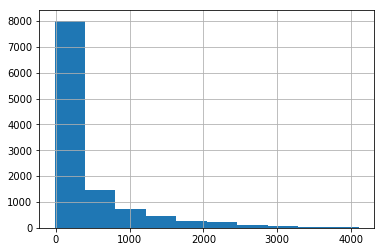

In [62]:
admissions_df.days_between_admit.hist()

## Extract Discharge Summary notes from NOTEEVENTS table

In [77]:
# define NOTEEVENTES table
notes = Table('noteevents', metadata, autoload=True, autoload_with=engine)

# Print the column names
print('COLUMN NAMES')
print(notes.columns.keys())

# Print full table metadata
print('\nMETADATA')
print(repr(notes))

COLUMN NAMES
['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime', 'storetime', 'category', 'description', 'cgid', 'iserror', 'text']

METADATA
Table('noteevents', MetaData(bind=None), Column('row_id', INTEGER(), table=<noteevents>, primary_key=True, nullable=False), Column('subject_id', INTEGER(), table=<noteevents>, nullable=False), Column('hadm_id', INTEGER(), table=<noteevents>), Column('chartdate', TIMESTAMP(precision=0), table=<noteevents>), Column('charttime', TIMESTAMP(precision=0), table=<noteevents>), Column('storetime', TIMESTAMP(precision=0), table=<noteevents>), Column('category', VARCHAR(length=50), table=<noteevents>), Column('description', VARCHAR(length=255), table=<noteevents>), Column('cgid', INTEGER(), table=<noteevents>), Column('iserror', CHAR(length=1), table=<noteevents>), Column('text', TEXT(), table=<noteevents>), schema=None)


In [63]:
# extract Discharge
query = "SELECT subject_id, hadm_id, category, text \
        FROM noteevents \
        WHERE category='Discharge summary'"
discharge_query = connection.execute(query).fetchall()

In [64]:
# create DataFrame
discharge_df = pd.DataFrame.from_records(discharge_query, 
                                         columns=['subject_id','hadm_id','category','text'])
print(discharge_df.shape)
discharge_df.head(3)

(59652, 4)


,subject_id,hadm_id,category,text
0,22532,167853,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118,Discharge summary,Admission Date: [**2119-5-4**] D...


In [65]:
# if multiples exist, take the last HADM_ID entry
discharge_df = (discharge_df.groupby(['subject_id','hadm_id']).nth(-1)).reset_index()

In [66]:
assert discharge_df.duplicated(['hadm_id']).sum() == 0, 'Multiple discharge summaries per admission'

In [67]:
discharge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 4 columns):
subject_id    52726 non-null int64
hadm_id       52726 non-null int64
category      52726 non-null object
text          52726 non-null object
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


## Merge DataFrames

In [113]:
clinic_df = pd.merge(admissions_df[['subject_id','hadm_id','admission_time','discharge_time','next_admission','days_between_admit','admission_type','time_of_death']],
                        discharge_df[['subject_id','hadm_id','text']], 
                        on = ['subject_id','hadm_id'],
                        how = 'left')

# if multiples exist, take the last HADM_ID entry
#clinic_df = (clinic_df.groupby(['subject_id','hadm_id']).nth(-1)).reset_index()

assert len(clinic_df) == len(admissions_df), 'Number of rows increased'

In [114]:
clinic_df.head(3)

,subject_id,hadm_id,admission_time,discharge_time,next_admission,days_between_admit,admission_type,time_of_death,text
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NaN,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,NaN,EMERGENCY,NaT,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,NaN,EMERGENCY,NaT,Admission Date: [**2191-3-16**] Discharge...


In [115]:
clinic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58976 entries, 0 to 58975
Data columns (total 9 columns):
subject_id            58976 non-null int64
hadm_id               58976 non-null int64
admission_time        58976 non-null datetime64[ns]
discharge_time        58976 non-null datetime64[ns]
next_admission        11399 non-null datetime64[ns]
days_between_admit    11399 non-null float64
admission_type        58976 non-null object
time_of_death         5854 non-null datetime64[ns]
text                  52726 non-null object
dtypes: datetime64[ns](4), float64(1), int64(2), object(2)
memory usage: 4.5+ MB


In [116]:
perc_missing = clinic_df.text.isna().sum() / len(clinic_df) * 100
print('{:.2f}% of text cells are empty.'.format(perc_missing))
print('-'*40)
for adm_type in clinic_df.admission_type.unique():
    txt_missing = clinic_df[clinic_df.admission_type == adm_type].text.isna().sum() / len(clinic_df[clinic_df.admission_type == adm_type]) * 100
    print('{:.2f}% of {} text cells are empty.'.format(txt_missing, adm_type))

10.60% of text cells are empty.
----------------------------------------
53.67% of NEWBORN text cells are empty.
3.80% of EMERGENCY text cells are empty.
4.87% of ELECTIVE text cells are empty.
4.27% of URGENT text cells are empty.


In [117]:
# drop all rows where Text cell is empty
clinic_df_clean = clinic_df[clinic_df.text.notnull()].copy()
clinic_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52726 entries, 1 to 58975
Data columns (total 9 columns):
subject_id            52726 non-null int64
hadm_id               52726 non-null int64
admission_time        52726 non-null datetime64[ns]
discharge_time        52726 non-null datetime64[ns]
next_admission        10933 non-null datetime64[ns]
days_between_admit    10933 non-null float64
admission_type        52726 non-null object
time_of_death         5263 non-null datetime64[ns]
text                  52726 non-null object
dtypes: datetime64[ns](4), float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [118]:
# add target column
# 1 = readmitted in last 30 days
clinic_df_clean['readmission'] = (clinic_df_clean.days_between_admit < 30).astype('int')

In [119]:
clinic_df_clean.head()

,subject_id,hadm_id,admission_time,discharge_time,next_admission,days_between_admit,admission_type,time_of_death,text,readmission
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,NaN,EMERGENCY,NaT,Admission Date: [**2101-10-20**] Discharg...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,NaN,EMERGENCY,NaT,Admission Date: [**2191-3-16**] Discharge...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,NaN,ELECTIVE,NaT,Admission Date: [**2175-5-30**] Dischar...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,NaT,NaN,EMERGENCY,2149-11-14 10:15:00,"Name: [**Known lastname 10050**], [**Known fi...",0
8,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaT,NaN,NEWBORN,NaT,Admission Date: [**2103-6-28**] Dischar...,0


In [151]:
# save file to CSV
clinic_df_clean.to_csv(PROJ_ROOT + '/data/processed/clinic_notes_data.csv')

5.76% of samples are in positive class


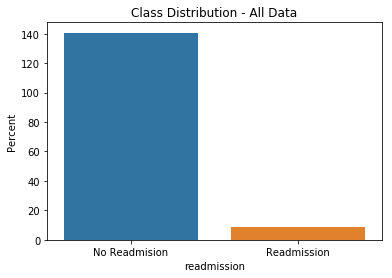

In [153]:
ax = sns.barplot(x='readmission', y='readmission',data=clinic_df_clean, estimator=lambda x: len(x) / len(y_train) * 100)
ax.set_ylabel("Percent")
ax.set_xticklabels(["No Readmision","Readmission"])
ax.set_title('Class Distribution - All Data')

pos_perc = clinic_df_clean.readmission.sum() / len(clinic_df_clean.readmission) * 100
print('{:.2f}% of samples are in positive class'.format(pos_perc))

## Split Data intro Train and Test Sets

In [154]:
# shuffle the samples
clinic_df_clean = clinic_df_clean.sample(n = len(clinic_df_clean), random_state = 42)
clinic_df_clean.reset_index(drop = True, inplace=True)

# Save 30% of the data as test a test set 
clinic_test=clinic_df_clean.sample(frac=0.30, random_state=42)

# use the rest of the data as training data
clinic_train=clinic_df_clean.drop(clinic_test.index)

Check to make sure we did not lose too much of the positive class while splitting the data.

5.71% of samples are in positive class


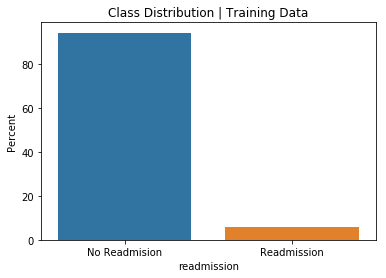

In [155]:
# plot class distribution of training set
ax = sns.barplot(x='readmission', y='readmission', data=clinic_train, 
                 estimator=lambda x: len(x) / len(clinic_train.readmission) * 100)
ax.set_ylabel("Percent")
ax.set_xticklabels(["No Readmision","Readmission"])
ax.set_title('Class Distribution | Training Data')

pos_perc = clinic_train.readmission.sum() / len(clinic_train.readmission) * 100
print('{:.2f}% of samples are in positive class'.format(pos_perc))

In [156]:
# save the test set to CSV
clinic_test.to_csv(PROJ_ROOT + '/data/processed/clinic_test_data.csv')

#save the training set to CSV
clinic_test.to_csv(PROJ_ROOT + '/data/processed/clinic_train_data.csv')